<a href="https://www.kaggle.com/code/serdargundogdu/gdz-enerji-makine-renmesi-lightgbm?scriptVersionId=126164947" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# İş Problemi

İzmir ve Manisa illerinde günlük yaşamın vazgeçilmezi olan elektrik enerjisini, insan odaklı hizmet anlayışı ve modern teknoloji sistemleri ile tüketicilerine ulaştıran Gdz Elektrik, geleneksel hale getirdiği Datathon serisinin ikincisinin çözümüdür.

Katılımcıların sunulan veri seti ile Gdz Elektrik sorumluluğundaki şebeke merkezlerine yönelik "enerji dağıtım" tahminleme yaklaşımı geliştirilmesi bekleniyor. 🎯

Kaggle yarışmasında başarı metriği MAPE (Mean Absolute Percentage Error) olacaktır.

# Veri Seti Hikayesi ve Değişkenler

Dosya

● med.csv - Major Event Day veri seti

● train.csv - Train veri seti

● sample_submission.csv - Örnek submission dosyası

Açıklamalar

Major Event Day (MED.CSV): Gün içindeki elektrik kesinti süresinin kabul edilebilir limiti aştığı gün.
Dolayısıyla kesinti olduysa o gün tahmin edilen enerjinin sapmasının yüksek olmasını bekleriz. Çünkü kesinti nedeniyle dağıtılamamış.

Dağıtılan Enerji: Watt: Aktif(yararlı) gücün birimi.
MWh = MegaWatt saat

Dağıtılan Enerji'nin %85'i İzmir, %15'i ise Manisa için gerçekleştirilmektedir.

Dış Veri Kullanımı
Size faydalı olabileceğini düşündüğünüz her türlü halka açık veriyi kullanabilirsiniz.

# Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
from sklearn.metrics import mean_absolute_percentage_error

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

# Veri Setinin Keşfi

In [2]:
df_med = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/med.csv', index_col='Tarih', parse_dates=True)
df_train = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/train.csv' , index_col='Tarih', parse_dates=True)
df_test = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv', index_col='Tarih', parse_dates=True)
df_all = pd.concat([df_train, df_test], axis=0)
df_all.reset_index(inplace=True)

* df_train veri setinde 1673 günlük 24'er saatlikveri vardır.

     df_train veri seti 2018-01-01 00:00:00 tarihinden 2022-07-31 23:00:00 tarihine kadar veri içermektedir.

* df_test veri setinde 31 günlük 24'er saatlik veri vardır.
    
    df_test veri seti 2022-08-01 00:00:00 tarihinden 2022-08-31 23:00:00 tarihine kadar veri içermektedir. 
    
* df_all veri setinde 1704 günlük 24'er saatlik veri vardır.
    
    df_all veri seti 2018-01-01 00:00:00 tarihinden 2022-08-31 23:00:00 tarihine kadar veri içermektedir. 

    "Dağıtılan Enerji (MWh)" = 0 olanlar df_test 
    
    "Dağıtılan Enerji (MWh)" > 0 olanlar df_train

In [3]:
df_all.head()

,Tarih,Dağıtılan Enerji (MWh)
0,2018-01-01 00:00:00,1593.944216
1,2018-01-01 01:00:00,1513.933887
2,2018-01-01 02:00:00,1402.612637
3,2018-01-01 03:00:00,1278.527266
4,2018-01-01 04:00:00,1220.697701


In [4]:
df_all.tail()

,Tarih,Dağıtılan Enerji (MWh)
40891,2022-08-31 19:00:00,0.0
40892,2022-08-31 20:00:00,0.0
40893,2022-08-31 21:00:00,0.0
40894,2022-08-31 22:00:00,0.0
40895,2022-08-31 23:00:00,0.0


In [5]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Dağıtılan Enerji (MWh),40152.0,1836.805287,426.066085,870.18328,1499.165048,1813.409221,2129.407998,3633.105297


In [6]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [7]:
check_df(df_train)

##################### Shape #####################
(40152, 1)
##################### Types #####################
Dağıtılan Enerji (MWh)    float64
dtype: object
##################### Head #####################
                     Dağıtılan Enerji (MWh)
Tarih                                      
2018-01-01 00:00:00             1593.944216
2018-01-01 01:00:00             1513.933887
2018-01-01 02:00:00             1402.612637
2018-01-01 03:00:00             1278.527266
2018-01-01 04:00:00             1220.697701
##################### Tail #####################
                     Dağıtılan Enerji (MWh)
Tarih                                      
2022-07-31 19:00:00             2492.489498
2022-07-31 20:00:00             2479.958245
2022-07-31 21:00:00             2485.016884
2022-07-31 22:00:00             2396.574255
2022-07-31 23:00:00             2285.252844
##################### NA #####################
Dağıtılan Enerji (MWh)    0
dtype: int64
##################### Quantiles #######

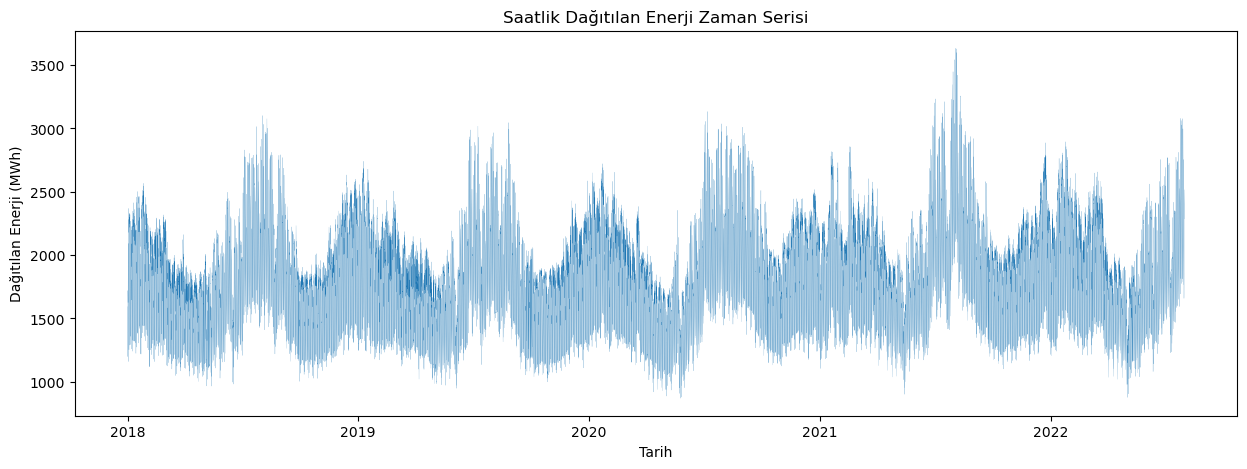

In [8]:
plt.figure(figsize=(15,5))
plt.title("Saatlik Dağıtılan Enerji Zaman Serisi")
plt.plot(df_train["Dağıtılan Enerji (MWh)"],linewidth=0.1)
plt.xlabel("Tarih")
plt.ylabel("Dağıtılan Enerji (MWh)")
plt.show()

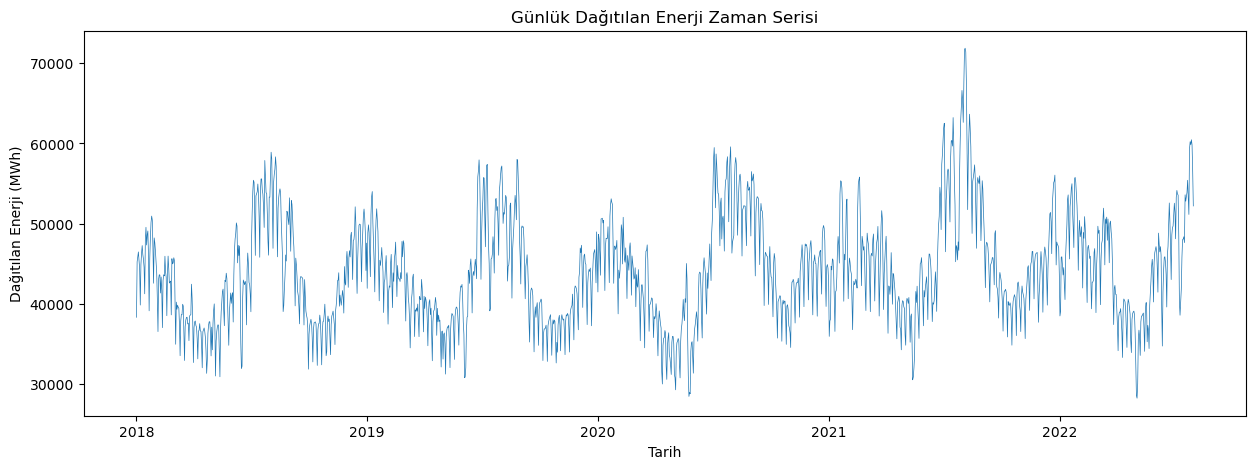

In [9]:
plt.figure(figsize=(15,5))
plt.title("Günlük Dağıtılan Enerji Zaman Serisi")
plt.plot(df_train['Dağıtılan Enerji (MWh)'].resample('D').sum(),linewidth=0.5)
plt.xlabel("Tarih")
plt.ylabel("Dağıtılan Enerji (MWh)")
plt.show()

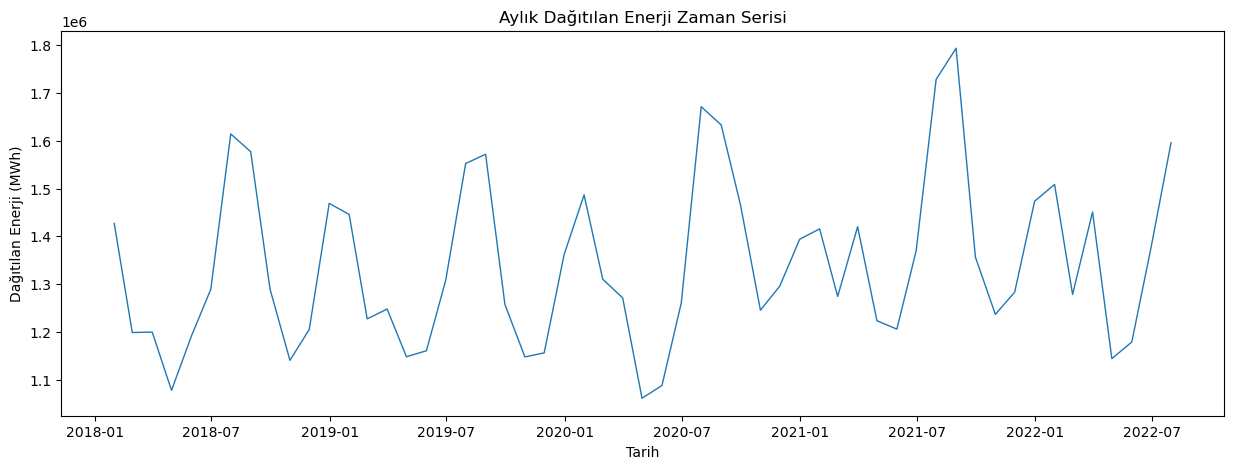

In [10]:
plt.figure(figsize=(15,5))
plt.title("Aylık Dağıtılan Enerji Zaman Serisi")
plt.plot(df_train['Dağıtılan Enerji (MWh)'].resample('M').sum(),linewidth=1)
plt.xlabel("Tarih")
plt.ylabel("Dağıtılan Enerji (MWh)")
plt.show()

# Makine Öğrenmesi ile Çözüm (LightGBM)

Veriler günlük ortalama değerlere çevirilip daha sonra saatlik Ağustos ayı dağılımlarına göre dağıtılacaktır.
2022 Ağustos ayı günleri tahmini için 2021 Ağustos ayı günleri değerleri validasyon verisi olarak alınacaktır.

In [11]:
train = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/train.csv', parse_dates=['Tarih'])

In [12]:
train.head()

,Tarih,Dağıtılan Enerji (MWh)
0,2018-01-01 00:00:00,1593.944216
1,2018-01-01 01:00:00,1513.933887
2,2018-01-01 02:00:00,1402.612637
3,2018-01-01 03:00:00,1278.527266
4,2018-01-01 04:00:00,1220.697701


In [13]:
train["Tarih"].min()

Timestamp('2018-01-01 00:00:00')

In [14]:
train["Tarih"].max()

Timestamp('2022-07-31 23:00:00')

In [15]:
def create_date_features(df, date_column):
    df['hour'] = df[date_column].dt.strftime("%H")
    df["hour"] = df["hour"].astype('int64')
    df['date'] = df[date_column].dt.strftime("%Y-%m-%d")
    df["date"] = pd.to_datetime(df["date"])
    df['month'] = df[date_column].dt.month
    df['day_of_month'] = df[date_column].dt.day
    df['day_of_year'] = df[date_column].dt.dayofyear
    df['week_of_year'] = df[date_column].dt.weekofyear
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['year'] = df[date_column].dt.year
    df["is_wknd"] = df[date_column].dt.weekday // 4
    df['is_month_start'] =df[date_column].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    df['quarter'] = df[date_column].dt.quarter
    df['is_quarter_start'] = df[date_column].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_column].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df[date_column].dt.is_year_start.astype(int)
    df['is_year_end'] = df[date_column].dt.is_year_end.astype(int)
    return df

df = create_date_features(df_all, "Tarih")
df.head()

,Tarih,Dağıtılan Enerji (MWh),hour,date,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,2018-01-01 00:00:00,1593.944216,0,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
1,2018-01-01 01:00:00,1513.933887,1,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
2,2018-01-01 02:00:00,1402.612637,2,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
3,2018-01-01 03:00:00,1278.527266,3,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
4,2018-01-01 04:00:00,1220.697701,4,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0


In [16]:
df_med.head()

""
Tarih
2019-12-23
2019-06-12
2019-01-25
2019-09-25
2019-03-29


In [17]:
df["is_med"] = 0

In [18]:
df.loc[df["date"].isin(df_med.index), "is_med"] = 1

In [19]:
df["is_med"].sum()

720

In [20]:
df.head()

,Tarih,Dağıtılan Enerji (MWh),hour,date,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_med
0,2018-01-01 00:00:00,1593.944216,0,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,0
1,2018-01-01 01:00:00,1513.933887,1,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,0
2,2018-01-01 02:00:00,1402.612637,2,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,0
3,2018-01-01 03:00:00,1278.527266,3,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,0
4,2018-01-01 04:00:00,1220.697701,4,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40896 entries, 0 to 40895
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Tarih                   40896 non-null  datetime64[ns]
 1   Dağıtılan Enerji (MWh)  40896 non-null  float64       
 2   hour                    40896 non-null  int64         
 3   date                    40896 non-null  datetime64[ns]
 4   month                   40896 non-null  int64         
 5   day_of_month            40896 non-null  int64         
 6   day_of_year             40896 non-null  int64         
 7   week_of_year            40896 non-null  int64         
 8   day_of_week             40896 non-null  int64         
 9   year                    40896 non-null  int64         
 10  is_wknd                 40896 non-null  int64         
 11  is_month_start          40896 non-null  int64         
 12  is_month_end            40896 non-null  int64 

In [22]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [23]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['enerji_lag_' + str(lag)] = dataframe['Dağıtılan Enerji (MWh)'].transform(lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [24]:
df.iloc[40895-17520]

Tarih                     2020-08-31 23:00:00
Dağıtılan Enerji (MWh)            2311.715018
hour                                       23
date                      2020-08-31 00:00:00
month                                       8
day_of_month                               31
day_of_year                               244
week_of_year                               36
day_of_week                                 0
year                                     2020
is_wknd                                     0
is_month_start                              0
is_month_end                                1
quarter                                     3
is_quarter_start                            0
is_quarter_end                              0
is_year_start                               0
is_year_end                                 0
is_med                                      0
Name: 23375, dtype: object

In [25]:
df.iloc[40895-18264]

Tarih                     2020-07-31 23:00:00
Dağıtılan Enerji (MWh)            2046.497523
hour                                       23
date                      2020-07-31 00:00:00
month                                       7
day_of_month                               31
day_of_year                               213
week_of_year                               31
day_of_week                                 4
year                                     2020
is_wknd                                     1
is_month_start                              0
is_month_end                                1
quarter                                     3
is_quarter_start                            0
is_quarter_end                              0
is_year_start                               0
is_year_end                                 0
is_med                                      0
Name: 22631, dtype: object

In [26]:
# one_month_ago_test_hourly_lag = [i for i in range(0, 745)]

In [27]:
one_year_ago_test_hourly_lag = [i for i in range(8760, 9505)]

In [28]:
two_year_ago_test_hourly_lag  = [i for i in range(17520, 18265)]

In [29]:
# three_year_ago_test_hourly_lag  = [i for i in range(25560, 26305)]

In [30]:
# lag_list = one_month_ago_test_hourly_lag
lag_list = one_year_ago_test_hourly_lag
lag_list.extend(two_year_ago_test_hourly_lag)
# lag_list.extend(three_year_ago_test_hourly_lag)

In [31]:
df = lag_features(df, lag_list)

In [32]:
df.shape

(40896, 1509)

In [33]:
df.tail()

Tarih  Dağıtılan Enerji (MWh)  hour       date  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  is_med  enerji_lag_8760  enerji_lag_8761  enerji_lag_8762  enerji_lag_8763  enerji_lag_8764  enerji_lag_8765  enerji_lag_8766  enerji_lag_8767  enerji_lag_8768  enerji_lag_8769  enerji_lag_8770  enerji_lag_8771  enerji_lag_8772  enerji_lag_8773  \
40891 2022-08-31 19:00:00                     0.0    19 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2539.194368      2603.404907      2773.116183      2877.137999      2912.076801      2919.794376      2829.561816      2692.864478      2711.694530      2597.863752      2430.845654      2108.750846      1712.215123      1615.675108   
40892 2022-08-31 20:00:00                     0.0    20 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2572.656001      2538.169712      2605.306967      2772.533205      2875.361252      2913.340769      2920.953502      2828.412427      2700.023910      2714.873904      2599.390048      2433.442528      2108.342668      1710.202622   
40893 2022-08-31 21:00:00                     0.0    21 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2487.239987      2571.481112      2537.613208      2604.335781      2771.767933      2874.156601      2913.042364      2921.565282      2829.894578      2696.298304      2716.582458      2599.785636      2432.298702      2109.825080   
40894 2022-08-31 22:00:00                     0.0    22 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2348.115235      2487.866169      2573.773313      2538.528392      2605.487037      2770.494968      2872.673953      2911.368539      2919.234528      2830.022058      2698.345495      2714.234078      2597.189678      2431.143226   
40895 2022-08-31 23:00:00                     0.0    23 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2210.896164      2348.408588      2483.297974      2572.457280      2541.618451      2604.532429      2772.784378      2874.693150      2910.506612      2921.156890      2828.985295      2699.993764      2714.489710      2599.847820   

       enerji_lag_8774  enerji_lag_8775  enerji_lag_8776  enerji_lag_8777  enerji_lag_8778  enerji_lag_8779  enerji_lag_8780  enerji_lag_8781  enerji_lag_8782  enerji_lag_8783  enerji_lag_8784  enerji_lag_8785  enerji_lag_8786  enerji_lag_8787  enerji_lag_8788  enerji_lag_8789  enerji_lag_8790  enerji_lag_8791  enerji_lag_8792  enerji_lag_8793  enerji_lag_8794  enerji_lag_8795  enerji_lag_8796  enerji_lag_8797  enerji_lag_8798  enerji_lag_8799  enerji_lag_8800  enerji_lag_8801  \
40891      1607.112331      1621.337186      1659.551586      1724.851345      1819.381396      1972.648030      2113.114006      2240.280741      2364.875859      2466.769959      2439.228347      2492.166752      2554.236211      2592.580243      2592.966431      2601.001494      2523.909349      2438.059979      2423.906027      2269.214506      2090.804208      1830.289404      1541.778017      1491.270084      1506.047743      1525.158879      1550.841816      1631.438077   
40892      1617.860323      1611.310706      1623.016310      1660.340608      1723.976869 

In [34]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['enerji_roll_mean_' + str(window)] = dataframe['Dağıtılan Enerji (MWh)'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=24, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

In [35]:
df = roll_mean_features(df, [8760, 17520])

In [36]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['enerji_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] =\
            dataframe['Dağıtılan Enerji (MWh)'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [37]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [8760, 17520]

In [38]:
df = ewm_features(df, alphas, lags)
df.tail()

Tarih  Dağıtılan Enerji (MWh)  hour       date  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  is_med  enerji_lag_8760  enerji_lag_8761  enerji_lag_8762  enerji_lag_8763  enerji_lag_8764  enerji_lag_8765  enerji_lag_8766  enerji_lag_8767  enerji_lag_8768  enerji_lag_8769  enerji_lag_8770  enerji_lag_8771  enerji_lag_8772  enerji_lag_8773  \
40891 2022-08-31 19:00:00                     0.0    19 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2539.194368      2603.404907      2773.116183      2877.137999      2912.076801      2919.794376      2829.561816      2692.864478      2711.694530      2597.863752      2430.845654      2108.750846      1712.215123      1615.675108   
40892 2022-08-31 20:00:00                     0.0    20 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2572.656001      2538.169712      2605.306967      2772.533205      2875.361252      2913.340769      2920.953502      2828.412427      2700.023910      2714.873904      2599.390048      2433.442528      2108.342668      1710.202622   
40893 2022-08-31 21:00:00                     0.0    21 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2487.239987      2571.481112      2537.613208      2604.335781      2771.767933      2874.156601      2913.042364      2921.565282      2829.894578      2696.298304      2716.582458      2599.785636      2432.298702      2109.825080   
40894 2022-08-31 22:00:00                     0.0    22 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2348.115235      2487.866169      2573.773313      2538.528392      2605.487037      2770.494968      2872.673953      2911.368539      2919.234528      2830.022058      2698.345495      2714.234078      2597.189678      2431.143226   
40895 2022-08-31 23:00:00                     0.0    23 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2210.896164      2348.408588      2483.297974      2572.457280      2541.618451      2604.532429      2772.784378      2874.693150      2910.506612      2921.156890      2828.985295      2699.993764      2714.489710      2599.847820   

       enerji_lag_8774  enerji_lag_8775  enerji_lag_8776  enerji_lag_8777  enerji_lag_8778  enerji_lag_8779  enerji_lag_8780  enerji_lag_8781  enerji_lag_8782  enerji_lag_8783  enerji_lag_8784  enerji_lag_8785  enerji_lag_8786  enerji_lag_8787  enerji_lag_8788  enerji_lag_8789  enerji_lag_8790  enerji_lag_8791  enerji_lag_8792  enerji_lag_8793  enerji_lag_8794  enerji_lag_8795  enerji_lag_8796  enerji_lag_8797  enerji_lag_8798  enerji_lag_8799  enerji_lag_8800  enerji_lag_8801  \
40891      1607.112331      1621.337186      1659.551586      1724.851345      1819.381396      1972.648030      2113.114006      2240.280741      2364.875859      2466.769959      2439.228347      2492.166752      2554.236211      2592.580243      2592.966431      2601.001494      2523.909349      2438.059979      2423.906027      2269.214506      2090.804208      1830.289404      1541.778017      1491.270084      1506.047743      1525.158879      1550.841816      1631.438077   
40892      1617.860323      1611.310706      1623.016310      1660.340608      1723.976869 

In [39]:
df = pd.get_dummies(df, columns=['hour','day_of_week', 'month'])

In [40]:
df['Dağıtılan Enerji (MWh)'] = np.log1p(df["Dağıtılan Enerji (MWh)"].values)

In [41]:
train = df.loc[(df["date"] < "2021-08-01"), :]

In [42]:
val = df.loc[(df["date"] >= "2021-08-01") & ((df["date"] < "2021-09-01")), :]

In [43]:
train.head()

,Tarih,Dağıtılan Enerji (MWh),date,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_med,enerji_lag_8760,enerji_lag_8761,enerji_lag_8762,enerji_lag_8763,enerji_lag_8764,enerji_lag_8765,enerji_lag_8766,enerji_lag_8767,enerji_lag_8768,enerji_lag_8769,enerji_lag_8770,enerji_lag_8771,enerji_lag_8772,enerji_lag_8773,enerji_lag_8774,enerji_lag_8775,enerji_lag_8776,enerji_lag_8777,enerji_lag_8778,enerji_lag_8779,enerji_lag_8780,enerji_lag_8781,enerji_lag_8782,enerji_lag_8783,enerji_lag_8784,enerji_lag_8785,enerji_lag_8786,enerji_lag_8787,enerji_lag_8788,enerji_lag_8789,enerji_lag_8790,enerji_lag_8791,enerji_lag_8792,enerji_lag_8793,enerji_lag_8794,enerji_lag_8795,enerji_lag_8796,enerji_lag_8797,enerji_lag_8798,enerji_lag_8799,enerji_lag_8800,enerji_lag_8801,enerji_lag_8802,enerji_lag_8803,enerji_lag_8804,enerji_lag_8805,enerji_lag_8806,enerji_lag_8807,enerji_lag_8808,enerji_lag_8809,enerji_lag_8810,enerji_lag_8811,enerji_lag_8812,enerji_lag_8813,enerji_lag_8814,enerji_lag_8815,enerji_lag_8816,enerji_lag_8817,enerji_lag_8818,enerji_lag_8819,enerji_lag_8820,enerji_lag_8821,enerji_lag_8822,enerji_lag_8823,enerji_lag_8824,enerji_lag_8825,enerji_lag_8826,enerji_lag_8827,enerji_lag_8828,enerji_lag_8829,enerji_lag_8830,enerji_lag_8831,enerji_lag_8832,enerji_lag_8833,enerji_lag_8834,enerji_lag_8835,enerji_lag_8836,enerji_lag_8837,enerji_lag_8838,enerji_lag_8839,enerji_lag_8840,enerji_lag_8841,enerji_lag_8842,enerji_lag_8843,enerji_lag_8844,enerji_lag_8845,enerji_lag_8846,enerji_lag_8847,enerji_lag_8848,enerji_lag_8849,enerji_lag_8850,enerji_lag_8851,enerji_lag_8852,enerji_lag_8853,enerji_lag_8854,enerji_lag_8855,enerji_lag_8856,enerji_lag_8857,enerji_lag_8858,enerji_lag_8859,enerji_lag_8860,enerji_lag_8861,enerji_lag_8862,enerji_lag_8863,enerji_lag_8864,enerji_lag_8865,enerji_lag_8866,enerji_lag_8867,enerji_lag_8868,enerji_lag_8869,enerji_lag_8870,enerji_lag_8871,enerji_lag_8872,enerji_lag_8873,enerji_lag_8874,enerji_lag_8875,enerji_lag_8876,enerji_lag_8877,enerji_lag_8878,enerji_lag_8879,enerji_lag_8880,enerji_lag_8881,enerji_lag_8882,enerji_lag_8883,enerji_lag_8884,enerji_lag_8885,enerji_lag_8886,enerji_lag_8887,enerji_lag_8888,enerji_lag_8889,enerji_lag_8890,enerji_lag_8891,enerji_lag_8892,enerji_lag_8893,enerji_lag_8894,enerji_lag_8895,enerji_lag_8896,enerji_lag_8897,enerji_lag_8898,enerji_lag_8899,enerji_lag_8900,enerji_lag_8901,enerji_lag_8902,enerji_lag_8903,enerji_lag_8904,enerji_lag_8905,enerji_lag_8906,enerji_lag_8907,enerji_lag_8908,enerji_lag_8909,enerji_lag_8910,enerji_lag_8911,enerji_lag_8912,enerji_lag_8913,enerji_lag_8914,enerji_lag_8915,enerji_lag_8916,enerji_lag_8917,enerji_lag_8918,enerji_lag_8919,enerji_lag_8920,enerji_lag_8921,enerji_lag_8922,enerji_lag_8923,enerji_lag_8924,enerji_lag_8925,enerji_lag_8926,enerji_lag_8927,enerji_lag_8928,enerji_lag_8929,enerji_lag_8930,enerji_lag_8931,enerji_lag_8932,enerji_lag_8933,enerji_lag_8934,enerji_lag_8935,enerji_lag_8936,enerji_lag_8937,enerji_lag_8938,enerji_lag_8939,enerji_lag_8940,enerji_lag_8941,enerji_lag_8942,enerji_lag_8943,enerji_lag_8944,enerji_lag_8945,enerji_lag_8946,enerji_lag_8947,enerji_lag_8948,enerji_lag_8949,enerji_lag_8950,enerji_lag_8951,enerji_lag_8952,enerji_lag_8953,enerji_lag_8954,enerji_lag_8955,enerji_lag_8956,enerji_lag_8957,enerji_lag_8958,enerji_lag_8959,enerji_lag_8960,enerji_lag_8961,enerji_lag_8962,enerji_lag_8963,enerji_lag_8964,enerji_lag_8965,enerji_lag_8966,enerji_lag_8967,enerji_lag_8968,enerji_lag_8969,enerji_lag_8970,enerji_lag_8971,enerji_lag_8972,enerji_lag_8973,enerji_lag_8974,enerji_lag_8975,enerji_lag_8976,enerji_lag_8977,enerji_lag_8978,enerji_lag_8979,enerji_lag_8980,enerji_lag_8981,enerji_lag_8982,enerji_lag_8983,enerji_lag_8984,enerji_lag_8985,enerji_lag_8986,enerji_lag_8987,enerji_lag_8988,enerji_lag_8989,enerji_lag_8990,enerji_lag_8991,enerji_lag_8992,enerji_lag_8993,enerji_lag_8994,enerji_lag_8995,enerji_lag_8996,enerji_lag_8997,enerj

In [44]:
cols = [col for col in train.columns if col not in ['Tarih', 'date', "Dağıtılan Enerji (MWh)", "year" ]]

In [45]:
Y_train = train['Dağıtılan Enerji (MWh)']
X_train = train[cols]

In [46]:
Y_val = val['Dağıtılan Enerji (MWh)']
X_val = val[cols]

In [47]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((31392,), (31392, 1557), (744,), (744, 1557))

In [48]:
lgb_params = {'metric': {'mape'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 200,
              'nthread': -1}


In [49]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [50]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  verbose_eval=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.720252 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's mape: 0.0127219	valid_1's mape: 0.0158525
[200]	training's mape: 0.0100269	valid_1's mape: 0.0118051
[300]	training's mape: 0.00872688	valid_1's mape: 0.0108484
[400]	training's mape: 0.00791881	valid_1's mape: 0.0105132
[500]	training's mape: 0.00738089	valid_1's mape: 0.0104441
[600]	training's mape: 0.00696387	valid_1's mape: 0.0103793
[700]	training's mape: 0.00665332	valid_1's mape: 0.0105298
[800]	training's mape: 0.00639513	valid_1's mape: 0.0106615
Early stopping, best iteration is:
[605]	training's mape: 0.00694582	valid_1's mape: 0.0103786


In [51]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [52]:
mean_absolute_percentage_error(np.expm1(y_pred_val), np.expm1(Y_val))

0.08684143317963447

In [53]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
     'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show(block=True)
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(model, num=200)

                    feature  split       gain
156         enerji_lag_8904    183  36.080448
324         enerji_lag_9072     69  11.744022
492         enerji_lag_9240     78   4.842526
1502  enerji_roll_mean_8760    374   4.747263
1               day_of_year    441   2.863000
...                     ...    ...        ...
152         enerji_lag_8900      1   0.013648
477         enerji_lag_9225      7   0.013588
85          enerji_lag_8833      2   0.013448
291         enerji_lag_9039      3   0.013353
714         enerji_lag_9462      7   0.013282

[200 rows x 3 columns]


,feature,split,gain
156,enerji_lag_8904,183,36.080448
324,enerji_lag_9072,69,11.744022
492,enerji_lag_9240,78,4.842526
1502,enerji_roll_mean_8760,374,4.747263
1,day_of_year,441,2.863000
...,...,...,...
824,enerji_lag_17587,0,0.000000
826,enerji_lag_17589,0,0.000000
827,enerji_lag_17590,0,0.000000
828,enerji_lag_17591,0,0.000000


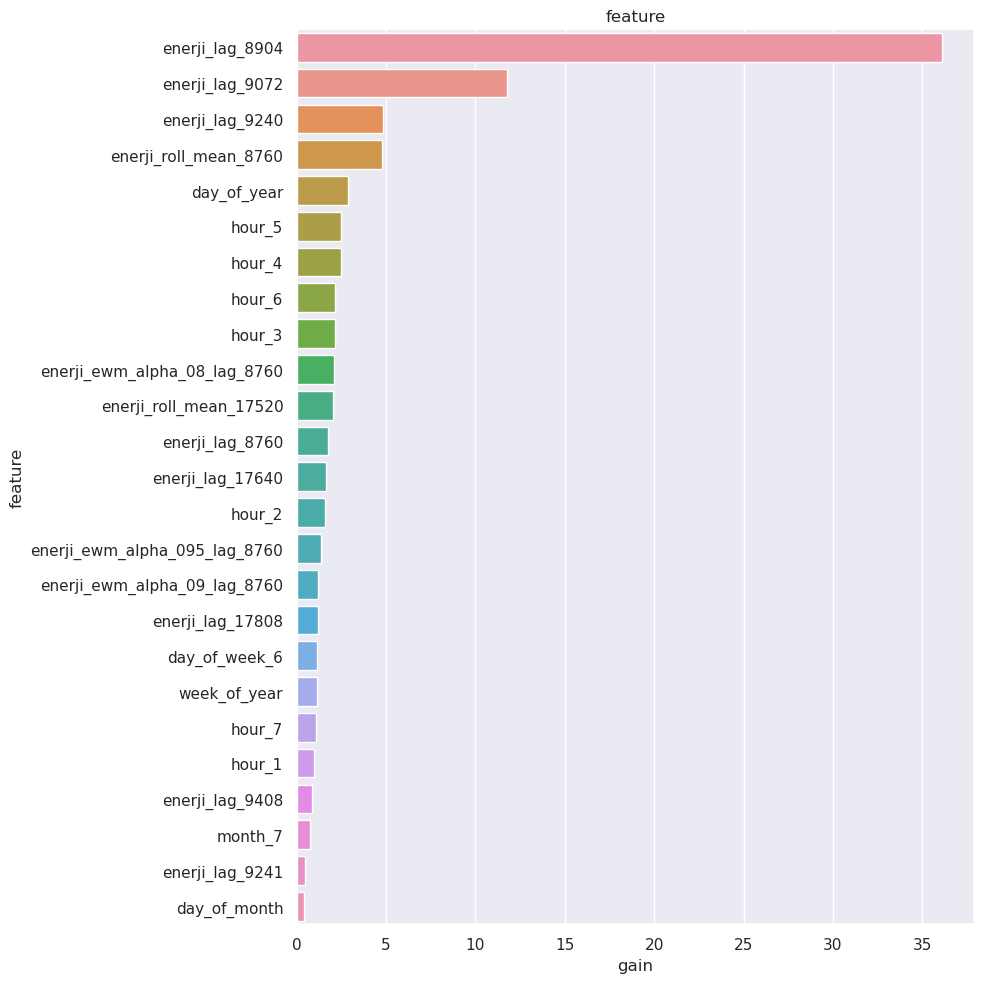

                    feature  split       gain
156         enerji_lag_8904    183  36.080448
324         enerji_lag_9072     69  11.744022
492         enerji_lag_9240     78   4.842526
1502  enerji_roll_mean_8760    374   4.747263
1               day_of_year    441   2.863000
...                     ...    ...        ...
152         enerji_lag_8900      1   0.013648
477         enerji_lag_9225      7   0.013588
85          enerji_lag_8833      2   0.013448
291         enerji_lag_9039      3   0.013353
714         enerji_lag_9462      7   0.013282

[200 rows x 3 columns]


513

In [54]:
plot_lgb_importances(model, num=30, plot=True)

feat_imp = plot_lgb_importances(model, num=200)

# önem seviyesine göre gain değerleri 0 olanlar seçilip modelden çıkartılması
importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

In [55]:
train = df.loc[~(df['Dağıtılan Enerji (MWh)'] == 0)]
Y_train = train['Dağıtılan Enerji (MWh)']
X_train = train[cols]
test = df.loc[df['Dağıtılan Enerji (MWh)'] == 0]
X_test = test[cols]

In [56]:
X_test.head()

day_of_month  day_of_year  week_of_year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  is_med  enerji_lag_8760  enerji_lag_8761  enerji_lag_8762  enerji_lag_8763  enerji_lag_8764  enerji_lag_8765  enerji_lag_8766  enerji_lag_8767  enerji_lag_8768  enerji_lag_8769  enerji_lag_8770  enerji_lag_8771  enerji_lag_8772  enerji_lag_8773  enerji_lag_8774  enerji_lag_8775  enerji_lag_8776  enerji_lag_8777  enerji_lag_8778  \
40152             1          213            31        0               1             0        3                 0               0              0            0       0      2569.779931      2725.466637      2845.855641      2962.167603      3000.683007      3049.349834      3126.426097      3177.225621      3202.482978      3213.566237      3225.696089      3164.161225      3063.159703      3012.582988      2860.838597      2650.801437      2350.028417      2049.623152      1970.520935   
40153             1          213            31        0               1             0        3                 0               0              0            0       0      2421.865282      2569.964853      2724.747080      2845.105904      2960.360806      3001.396831      3048.496332      3123.787276      3174.890072      3206.422213      3208.609154      3224.464809      3166.546975      3070.625683      3012.733874      2862.629767      2649.582626      2351.942680      2047.720712   
40154             1          213            31        0               1             0        3                 0               0              0            0       0      2285.273823      2424.332734      2568.072611      2726.856657      2845.783253      2959.911241      2997.722826      3048.216939      3122.818762      3178.302557      3202.175533      3212.917773      3225.815720      3168.709312      3065.726312      3011.332646      2860.204606      2652.667496      2352.468430   
40155             1          213            31        0               1             0        3                 0               0              0            0       0      2172.926749      2286.886503      2420.713078      2569.583539      2724.340777      2843.614529      2960.867348      2999.080077      3049.823290      3122.929061      3174.697406      3203.823821      3212.964920      3224.159407      3168.456662      3067.308956      3012.245364      2862.101758      2652.095772   
40156             1          213            31        0               1             0        3                 0               0              0            0       0      2083.963929      2175.276997      2285.068029      2422.751119      2571.573250      2723.456089      2843.046955      2962.032431      2997.332002      3049.234175      3123.593051      3179.176428      3200.847889      3210.135382      3225.580970      3165.273844      3067.019832      3012.814721      2861.853640   

       enerji_lag_8779  enerji_lag_8780  enerji_lag_8781  enerji_lag_8782  enerji_lag_8783  enerji_lag_8784  enerji_lag_8785  enerji_lag_8786  enerji_lag_8787  enerji_lag_8788  enerji_lag_8789  enerji_lag_8790  enerji_lag_8791  enerji_lag_8792  enerji_lag_8793  enerji_lag_8794  enerji_lag_8795  enerji_lag_8796  enerji_lag_8797  enerji_lag_8798  enerji_lag_8799  enerji_lag_8800  enerji_lag_8801  enerji_lag_8802  enerji_lag_8803  enerji_lag_8804  enerji_lag_8805  enerji_lag_8806  \
40152      2064.121648      2119.095792      2175.010521      2290.846178      2446.481723      2605.876959      2802.315048      2937.080072      3049.337312      3046.300211      3059.045261      3169.043099      3335.661845      3423.454227      3449.215441      3404.996819      3265.543773      3176.339091      3128.687053      2972.446553      2769.311663      2463.320927      2045.320293      1920.858280      1991.675014      2031.002833      2103.326134      2187.992217   
40153      1968.825029      2065.622910      2117.982858      2174.874292      2292.077032

In [57]:
Y_train.shape, X_train.shape, X_test.shape

((40152,), (40152, 1557), (744, 1557))

In [58]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.876183 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [59]:
df_test["Dağıtılan Enerji (MWh)"] = np.expm1(test_preds)

In [60]:
df_test.head()

,Dağıtılan Enerji (MWh)
Tarih,
2022-08-01 00:00:00,2240.714522
2022-08-01 01:00:00,2155.082370
2022-08-01 02:00:00,1924.876817
2022-08-01 03:00:00,1889.631984
2022-08-01 04:00:00,1879.029219


In [61]:
df_test.to_csv("submission.csv")

[542]	training's mape: 0.00717928	valid_1's mape: 0.0106979 Tersine logaritma alınarak 0.08989344920202877 ve submission 6.89243